In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import os

In [2]:
!pip install split_folders

In [3]:
import splitfolders
splitfolders.ratio("../input/ekush-dataset/female/female", output="./", seed=1337, ratio=(.8, .1, .1), group_prefix=None)
splitfolders.ratio("../input/ekush-dataset/male/male", output="./", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 186090 files [14:29, 214.11 files/s]
Copying files: 178067 files [15:08, 196.05 files/s]


In [4]:
NUM_CLASSES = len(os.listdir(r'./test'))
print(NUM_CLASSES)

122


In [5]:
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization, concatenate
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import tensorflow as tf

In [6]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(r'./train', # this is where you specify the path to the main data folder
                                                 target_size=(28,28),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=val_datagen.flow_from_directory(r'./val', # this is where you specify the path to the main data folder
                                                 target_size=(28,28),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 291123 images belonging to 122 classes.
Found 36302 images belonging to 122 classes.


In [7]:
model = Sequential()
input_layer = Input(shape=(28,28,3))
layer1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), padding='same')(input_layer)
layer2 = BatchNormalization()(layer1)
layer3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), padding='same')(layer2)
layer4 = BatchNormalization()(layer3)
layer5 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(layer4)
layer6 = Dropout(0.25)(layer5)

layer7 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), padding='same')(layer6)
layer8 = BatchNormalization()(layer7)
layer9 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(layer8)
layer10 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), padding='same')(layer9)
layer11 = Dropout(0.25)(layer10)

layer12 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), padding='same')(layer6)
layer13 = BatchNormalization()(layer12)
layer14 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), padding='same')(layer13)
layer15 = BatchNormalization()(layer14)
layer16 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(layer15)
layer17 = Dropout(0.25)(layer16)

layer18 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), padding='same')(layer6)
layer19 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), padding='same')(layer18)
layer20 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(layer19)
layer21 = Dropout(0.25)(layer20)

layer22 = concatenate([layer11, layer17, layer21])

layer23 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), padding='same')(layer22)
layer24 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(layer23)
layer25 = BatchNormalization()(layer24)
layer26 = Flatten()(layer25)
layer27 = Dense(2048, activation='relu')(layer26)
layer28 = Dropout(0.25)(layer27)
layer29 = Dense(1024, activation='relu')(layer28)
layer30 = Dropout(0.25)(layer29)
layer31 = Dense(NUM_CLASSES, activation='softmax')(layer30)

# output
model = Model(inputs=input_layer, outputs=layer31)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 32)   9248        ['batch_normalization[0][0]']

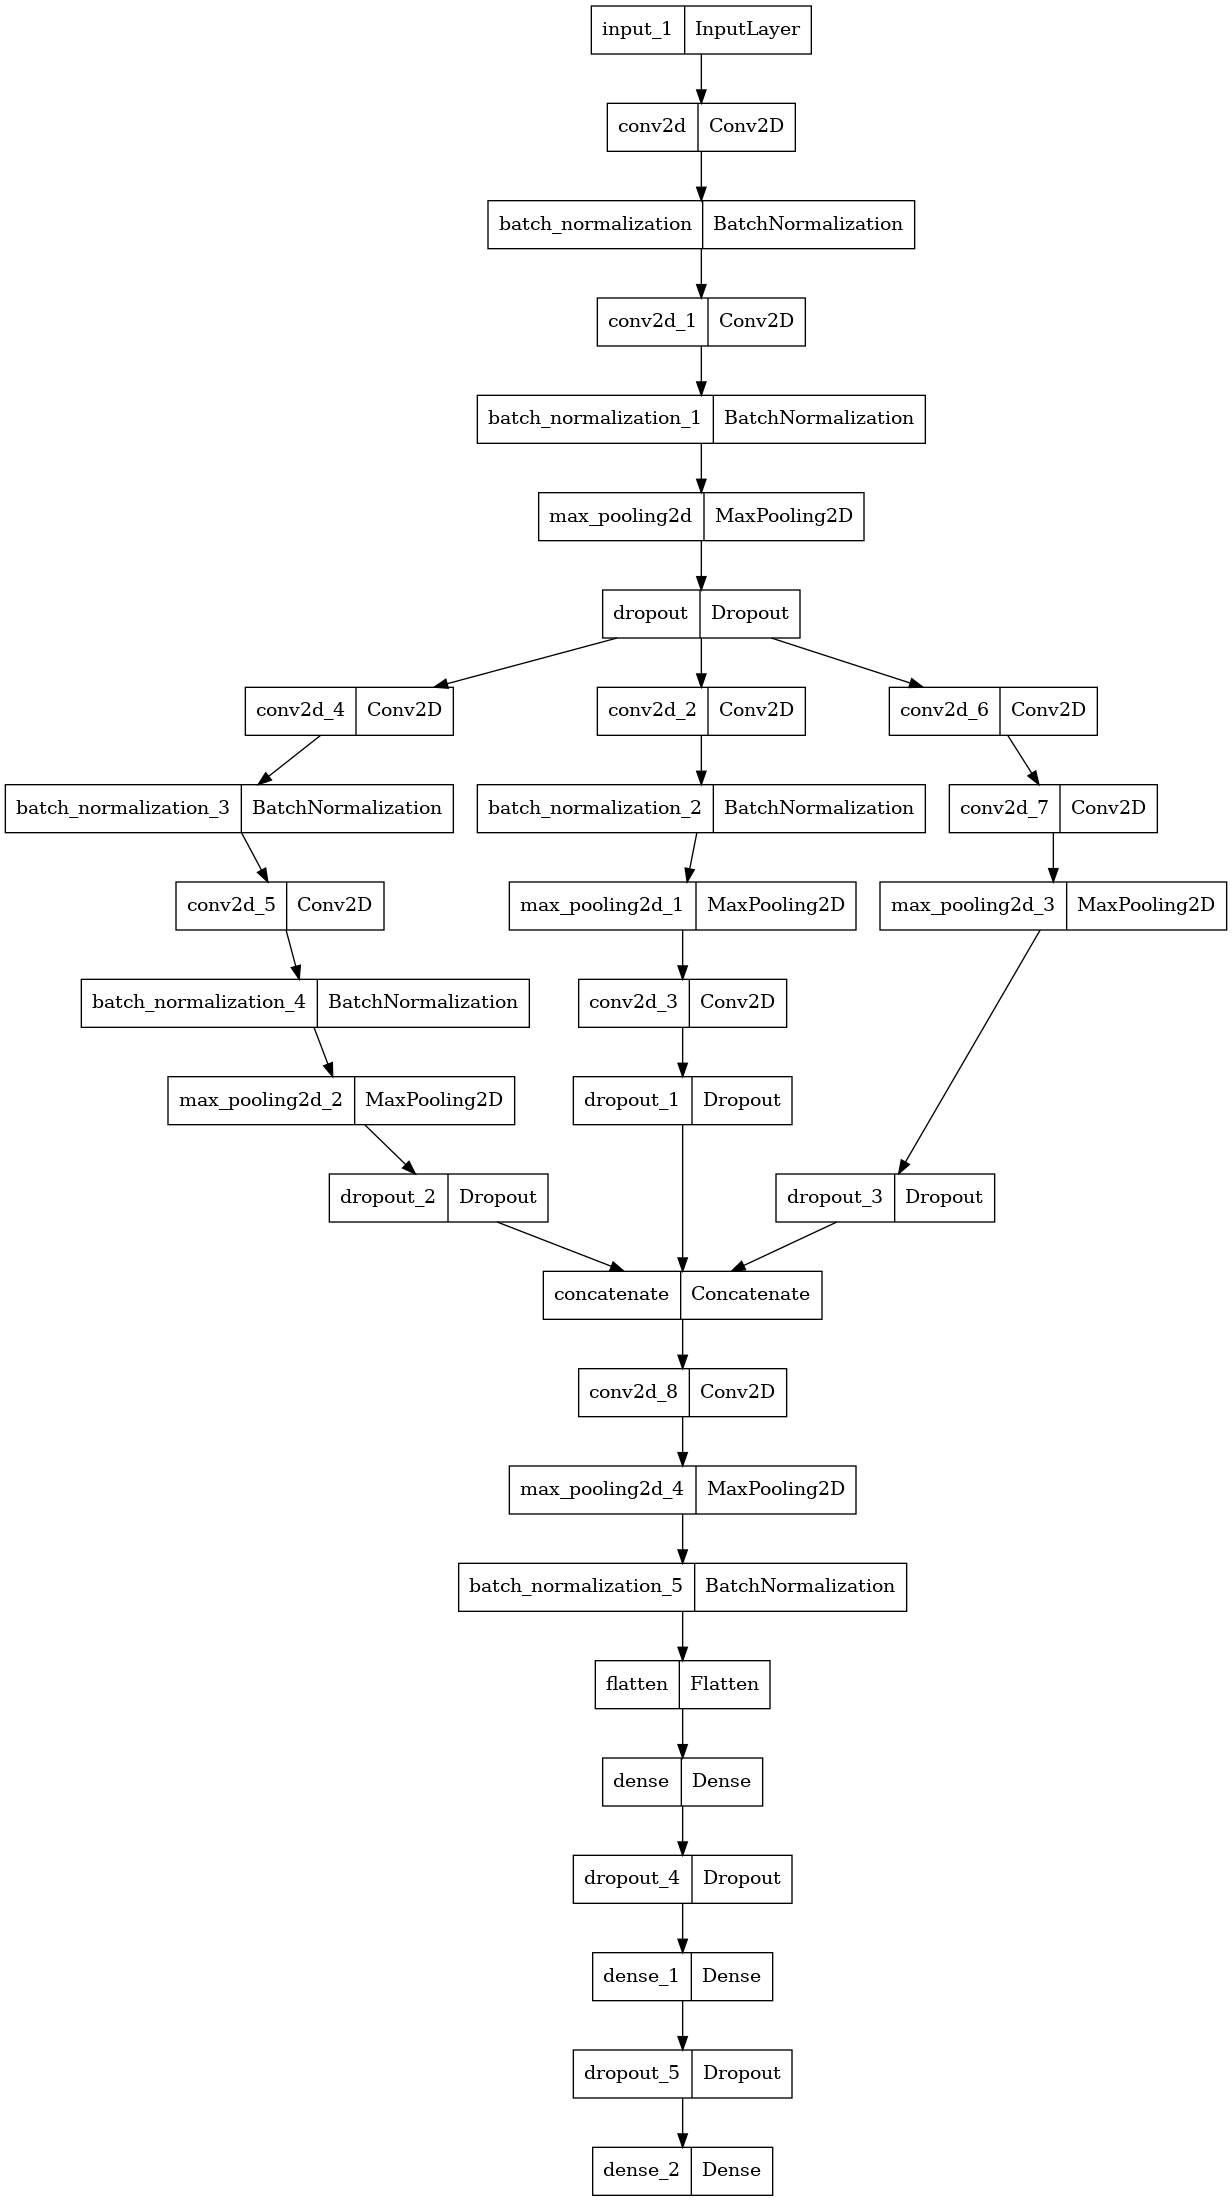

In [9]:
from keras.utils import plot_model
plot_model(model, to_file='multiple_inputs.png')

In [10]:
earlystop=EarlyStopping(patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001),
            loss=categorical_crossentropy,
            metrics=['accuracy'])

In [12]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size

history = model.fit(train_generator, 
                    steps_per_epoch=step_size_train, 
                    validation_data=val_generator, 
                    validation_steps=step_size_val, 
                    epochs=50,
                    callbacks=callback)

Epoch 1/50


2023-03-11 19:12:36.863091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


12130/12130 [==============================] - 437s 35ms/step - loss: 0.7294 - accuracy: 0.8064 - val_loss: 0.3560 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 2/50
12130/12130 [==============================] - 387s 32ms/step - loss: 0.3771 - accuracy: 0.8979 - val_loss: 0.2896 - val_accuracy: 0.9254 - lr: 0.0010
Epoch 3/50
12130/12130 [==============================] - 389s 32ms/step - loss: 0.3152 - accuracy: 0.9144 - val_loss: 0.2583 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 4/50
12130/12130 [==============================] - 392s 32ms/step - loss: 0.2838 - accuracy: 0.9233 - val_loss: 0.2672 - val_accuracy: 0.9357 - lr: 0.0010
Epoch 5/50
12130/12130 [==============================] - 381s 31ms/step - loss: 0.2665 - accuracy: 0.9277 - val_loss: 0.2552 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 6/50
12130/12130 [==============================] - 386s 32ms/step - loss: 0.2574 - accuracy: 0.9308 - val_loss: 0.2635 - val_accuracy: 0.9399 - lr: 0.0010
Epoch 7/50
12130/12130 [===============

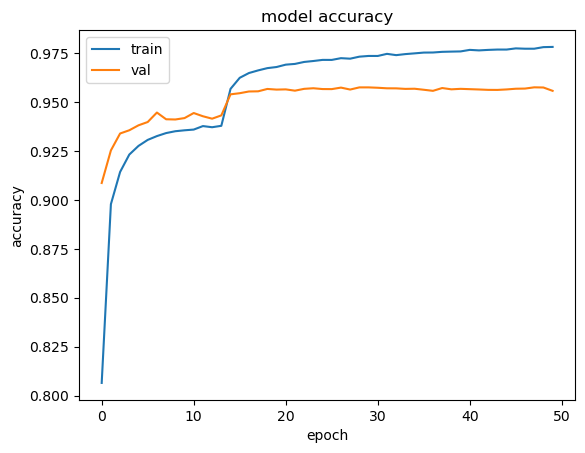

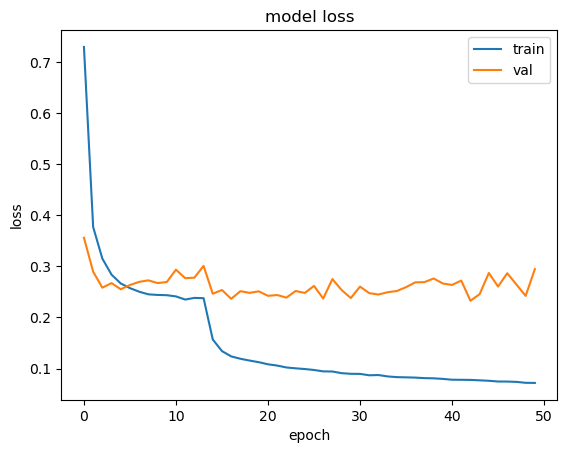

In [13]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [14]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(28,28),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 36622 images belonging to 122 classes.


In [15]:
pred=model.predict(test_generator,verbose=1,steps=test_generator.n/batch_size)

1525/1525 [==============================] - 40s 26ms/step


In [16]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)

                       Filename Predictions
0          0/0_BAG_18_2_382.jpg           0
1          0/0_BAR_12_1_391.jpg           0
2          0/0_BAR_12_1_392.jpg           0
3          0/0_BAR_14_1_406.jpg           0
4           0/0_BAR_22_3_11.jpg           0
...                         ...         ...
36617    99/1_SYL_11_1_1542.jpg          99
36618  99/1_Sher_19_3_00046.jpg          99
36619    99/1_TAN_12_1_1562.jpg          99
36620    99/1_TAN_12_1_1569.jpg          99
36621     99/1_TAN_1_1_1577.jpg          99

[36622 rows x 2 columns]


In [17]:
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

35018 1604


In [18]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       307
           1       0.98      0.98      0.98       310
           2       0.97      0.96      0.96       308
           3       0.98      0.94      0.96       306
           4       0.98      0.99      0.99       308
           5       0.99      0.99      0.99       309
           6       0.97      0.96      0.96       309
           7       0.94      0.93      0.94       309
           8       0.95      0.96      0.96       309
           9       0.97      0.97      0.97       306
          10       0.93      0.93      0.93       286
          11       0.99      0.98      0.99       307
          12       0.98      0.97      0.98       308
          13       0.96      0.99      0.97       310
          14       0.99      0.99      0.99       309
          15       0.97      0.99      0.98       309
          16       0.96      0.97      0.96       308
          17       0.92    

Class  0  Accuracy:  0.9771986970684039
Class  1  Accuracy:  0.9806451612903225
Class  2  Accuracy:  0.961038961038961
Class  3  Accuracy:  0.9379084967320261
Class  4  Accuracy:  0.987012987012987
Class  5  Accuracy:  0.9902912621359223
Class  6  Accuracy:  0.9611650485436893
Class  7  Accuracy:  0.9320388349514563
Class  8  Accuracy:  0.9644012944983819
Class  9  Accuracy:  0.9705882352941176
Class  10  Accuracy:  0.9300699300699301
Class  11  Accuracy:  0.9804560260586319
Class  12  Accuracy:  0.9675324675324676
Class  13  Accuracy:  0.9870967741935484
Class  14  Accuracy:  0.9902912621359223
Class  15  Accuracy:  0.9935275080906149
Class  16  Accuracy:  0.9707792207792207
Class  17  Accuracy:  0.9774193548387097
Class  18  Accuracy:  0.9902912621359223
Class  19  Accuracy:  0.961038961038961
Class  20  Accuracy:  0.9838187702265372
Class  21  Accuracy:  0.9514563106796117
Class  22  Accuracy:  0.9902912621359223
Class  23  Accuracy:  0.961038961038961
Class  24  Accuracy:  0.983870

<AxesSubplot:>

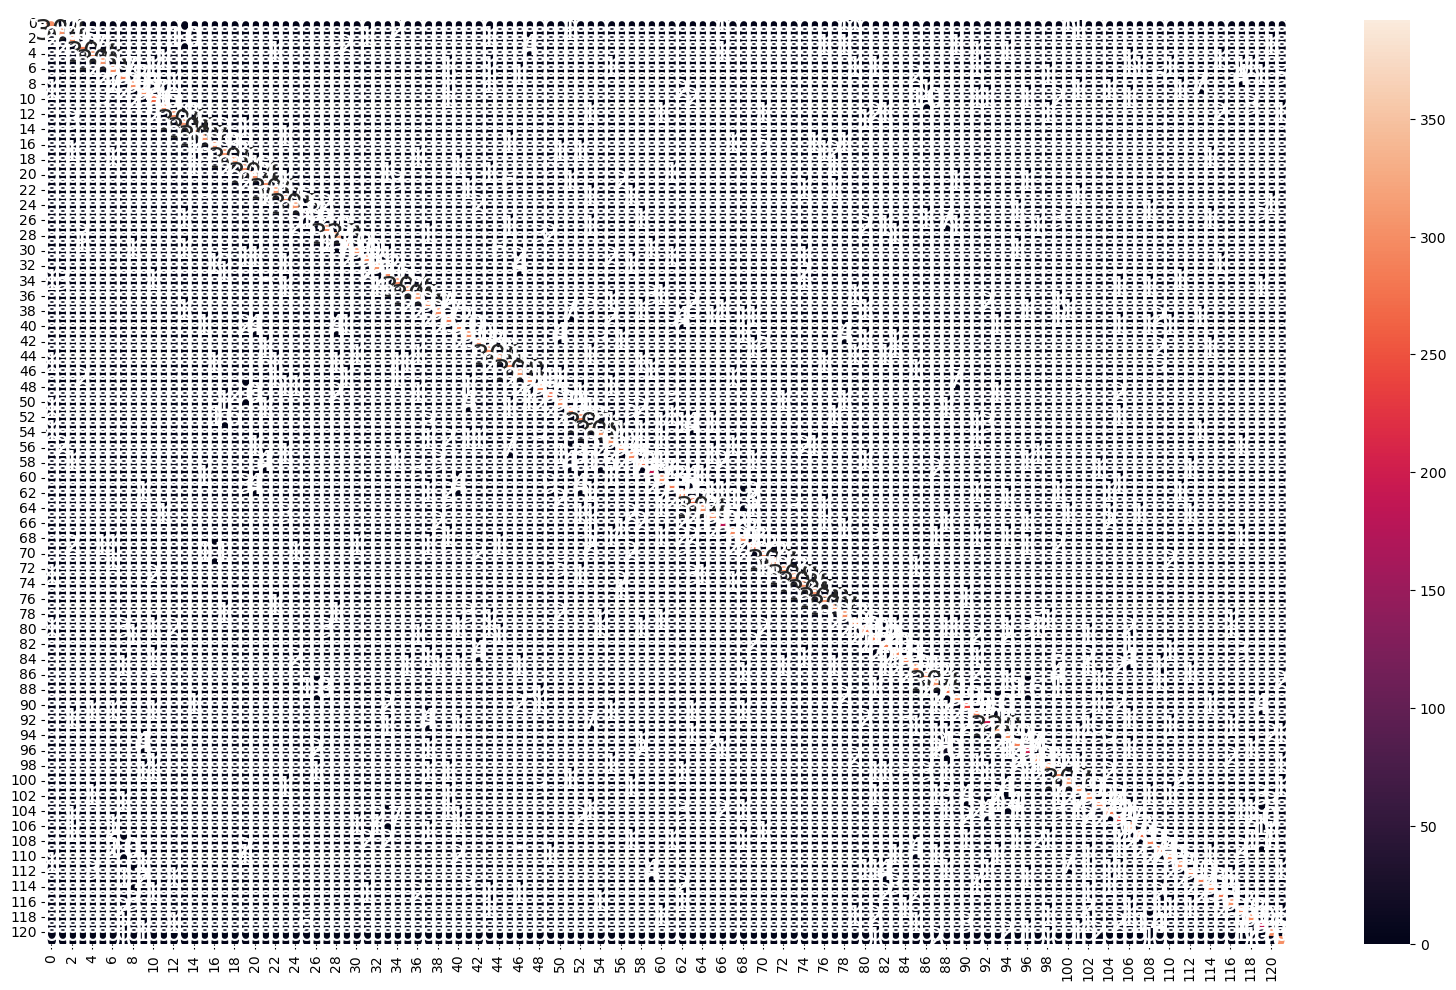

In [19]:
from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns

plt.figure(figsize = (20,12))
sns.heatmap(c, annot=True, annot_kws={"size": 20}, fmt='d')